In [44]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [14]:
data = pd.read_csv("/home/cp/DataSet/GMB(Groningen Meaning Bank) corpus/ner_dataset.csv", encoding="latin1")
data =data.fillna(method='ffill')


In [15]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [19]:
words = list(set(data["Word"]))
n_words = len(words)
tags = list(set(data["Tag"]))
n_tags = len(tags)

In [28]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data

        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [31]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [33]:
sentences = getter.sentences
print(sentences[:3])

[[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')], [('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'

In [34]:
max_len = 75
max_len_char = 10

In [36]:

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0#这种方法很好是直接少了定义词典的过程！！！借鉴

dx2word = {i: w for w, i in word2idx.items()}


tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0 
#对标签添加一个pad  所以在预测的时候 我们需要进行+1 多个预测类别
idx2tag = {i: w for w, i in tag2idx.items()}

In [38]:
#获取句子的单词对应的id
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
#将句子填充到最大长度
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [39]:
#获取字符集和 唯一的字符
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

98


In [40]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0 #的单词和字符都添加了 unk 和pad标识 tag只是添加 pad!!

In [41]:
#对每个句子填充到相同长度对每个单词填充到相同长度
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [64]:
#对标签的操作
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, 
                  sequences=y, 
                  value=tag2idx["PAD"], #对于填充的地方 补上pad id
                  padding='post', 
                  truncating='post')
print(y)#没有对y标签进行同——catagory所以后面的损失函数 是sparse_categorical_crossentropy

[[ 5  5  5 ...  0  0  0]
 [11  5  5 ...  0  0  0]
 [ 5  5  2 ...  0  0  0]
 ...
 [ 5 14  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 [ 5  1 10 ...  0  0  0]]


In [77]:
from sklearn.model_selection import train_test_split
#分割数据 为训练集和测试集
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, 
                                                    test_size=0.1, 
                                                    random_state=2018)
X_char_tr, X_char_te, _,  _ = train_test_split(X_char, y, 
                                              test_size=0.1, 
                                              random_state=2018)


In [66]:
# input and embedding for words
word_in = Input(shape=(max_len,),name ='word_in')
emb_word = Embedding(input_dim=n_words + 2, 
                     output_dim=20,
                     input_length=max_len, 
                     mask_zero=True,
                     name='emb_word')(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,),name ='char_in')
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, 
                                     output_dim=10,
                                     input_length=max_len_char, 
                                     mask_zero=True,
                                    ),name ='emb_char')(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, 
                                return_sequences=False,
                                recurrent_dropout=0.5
                                ),name ='char_lstm')(emb_char)
#print(char_enc)
#(?, 75, 10, 20) 当return_sequences=True 为false时候(?, 75, 20) 
#没有返回字符的序列长度
# main LSTM
x = concatenate([emb_word, char_enc],name ='concate')
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6
                             ), name ='main_lstm')(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"),name ='out')(main_lstm)

model = Model([word_in, char_in], out)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model,to_file = './LSTM_Char_Ner.png',show_shapes =True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
char_in (InputLayer)             (None, 75, 10)        0                                            
____________________________________________________________________________________________________
word_in (InputLayer)             (None, 75)            0                                            
____________________________________________________________________________________________________
emb_char (TimeDistributed)       (None, 75, 10, 10)    1000        char_in[0][0]                    
____________________________________________________________________________________________________
emb_word (Embedding)             (None, 75, 20)        703600      word_in[0][0]                    
___________________________________________________________________________________________

In [63]:

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["acc"])

In [65]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=8, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/8
38846/38846 [==============================] - 199s - loss: 0.3885 - acc: 0.9045 - val_loss: 0.1609 - val_acc: 0.9541
Epoch 2/8
38846/38846 [==============================] - 198s - loss: 0.1417 - acc: 0.9594 - val_loss: 0.1223 - val_acc: 0.9636
Epoch 3/8
38846/38846 [==============================] - 198s - loss: 0.1104 - acc: 0.9680 - val_loss: 0.1113 - val_acc: 0.9670
Epoch 4/8
38846/38846 [==============================] - 193s - loss: 0.0961 - acc: 0.9714 - val_loss: 0.1057 - val_acc: 0.9681
Epoch 5/8
38846/38846 [==============================] - 192s - loss: 0.0874 - acc: 0.9734 - val_loss: 0.1042 - val_acc: 0.9691
Epoch 6/8
38846/38846 [==============================] - 192s - loss: 0.0820 - acc: 0.9746 - val_loss: 0.1027 - val_acc: 0.9693
Epoch 7/8
38846/38846 [==============================] - 193s - loss: 0.0775 - acc: 0.9757 - val_loss: 0.1025 - val_acc: 0.9692
Epoch 8/8
38846/38846 [==============================] 

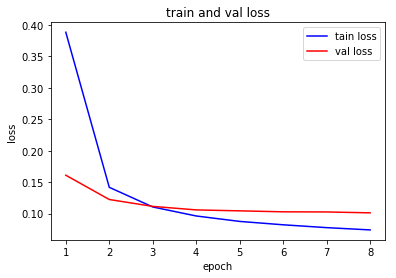

In [68]:
dic= history.history
loss = dic['loss']
val_loss = dic['val_loss']
epoch = range(1,len(loss)+1)
import matplotlib.pyplot as plt


plt.plot(epoch,loss,'b',label ='tain loss')
plt.plot(epoch,val_loss,'r',label ='val loss')
plt.title('train and val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()




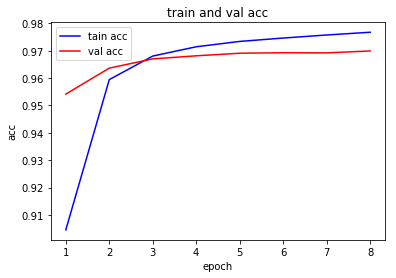

In [69]:
loss = dic['acc']
val_loss = dic['val_acc']
plt.plot(epoch,loss,'b',label ='tain acc')
plt.plot(epoch,val_loss,'r',label ='val acc')
plt.title('train and val acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()